In [15]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle

In [16]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

# Ar1 State Space models

In [31]:
SIGMA_Y = 3.2

def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val


def ar1_g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """    
    return total_noise * jnp.sqrt(TAU) * SIGMA_Y + all_particles


In [32]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 


def ar1_g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)



Optimal Functions

In [33]:
def ar1_optimal_sample(subkey, particles, Y_array, idt):

    mean_reversion_term = particles + TAU * KAPPA * (X_BAR - particles)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    new_particles = jax.random.normal(subkey, len(particles)) * jnp.sqrt(optimal_var) + optimal_mean
    
    return new_particles


def ar1_optimal_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean_reversion_term = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    proposal_term = jsp.stats.norm.logpdf(particle, optimal_mean, jnp.sqrt(optimal_var))

    f_term = jsp.stats.norm.logpdf(particle, mean_reversion_term, jnp.sqrt(TAU) * SIGMA_SIGMA)
    g_term = jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)

    return f_term + g_term - proposal_term


# Experiments

Show:
- Close to optimal ESS.
- Little differnce in MSE.
- Compare Filtering performance in a few ways.

Methodology:
This boils down to running the particle filter through for different data, collating the results and then plotting. 

In [34]:
TRAIN_KEY = jax.random.key(314)

In [35]:
# Building the Vehicle
ar1_vehicle = PFVehicle(f_from_noise, ar1_g_from_total_noise, f_likelihood_single, ar1_g_likelihood_single)

In [36]:
from nnp_functions.neural_networks import FeedForwardNetwork

# Training the NN method model 
inital_model = FeedForwardNetwork(1, 64, jax.random.key(0))
ar1_vehicle.train_model(
    TRAIN_KEY, 
    inital_model,
    1000,
    steps=5000,
    X_bar=X_BAR
)
ar1_nn_particle_filter = ar1_vehicle.build_NN_particle_filter(
    include_all_weights=True
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
from nnp_functions.particle_filter import ParticleFilter

# Building the optimal particle filter.
optimal_particle_filter = ParticleFilter(
    ar1_optimal_sample,
    ar1_optimal_likelihood_single,
    include_all_weights=True
)

### The main evaluation loop. 

In [ ]:
N_RUNS = 1
N_TIMESTEPS = 5000
N_PARTICLES = 2500

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
# 1. Use the vehicle to generate batched data 

x_vals, y_vals = ar1_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)
print("Data generation complete.")
print(f"x_vals shape: {x_vals.shape}, y_vals shape: {y_vals.shape}")

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)
print(f"Initial particles and log weights prepared. Shape: {initial_particles.shape}")

# 2. Use vmap to get the results for both particle filters. 
a_key, b_key = jax.random.split(EVAL_KEY, 2)

print("Running optimal particle filter simulations...")
_, _, optimal_diagnostics, opt_all_weights = jax.vmap(optimal_particle_filter.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(a_key, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("Optimal particle filter simulations complete.")

print("Running NN particle filter simulations...")
_, _, nn_diagnostics, nn_all_weights = jax.vmap(ar1_nn_particle_filter.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(b_key, N_RUNS),
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("NN particle filter simulations complete.")

Generating 1 runs of data with 5000 timesteps each...
Data generation complete.
x_vals shape: (1, 5000), y_vals shape: (1, 5000)
Initial particles and log weights prepared. Shape: (2500,)
Running optimal particle filter simulations...
Optimal particle filter simulations complete.
Running NN particle filter simulations...
NN particle filter simulations complete.


In [ ]:
print(jnp.average(nn_diagnostics['ess'][0]))

1622.2971


In [25]:
print(nn_all_weights[0].shape)
print(nn_all_weights[1].shape)

(1, 5000, 2500)
(1, 5000, 2500)


In [26]:
# Exclude: resample_flag, tail_coverage.

in_comparison_dict = ['ess', 'marginal_likelihood', 'mean_squared_error']
not_in_comparison = ['resample_flag', 'tail_coverage']
comparison_dict = {key: jnp.mean(optimal_diagnostics[key], axis=1) - jnp.mean(nn_diagnostics[key], axis=1) for key in in_comparison_dict}


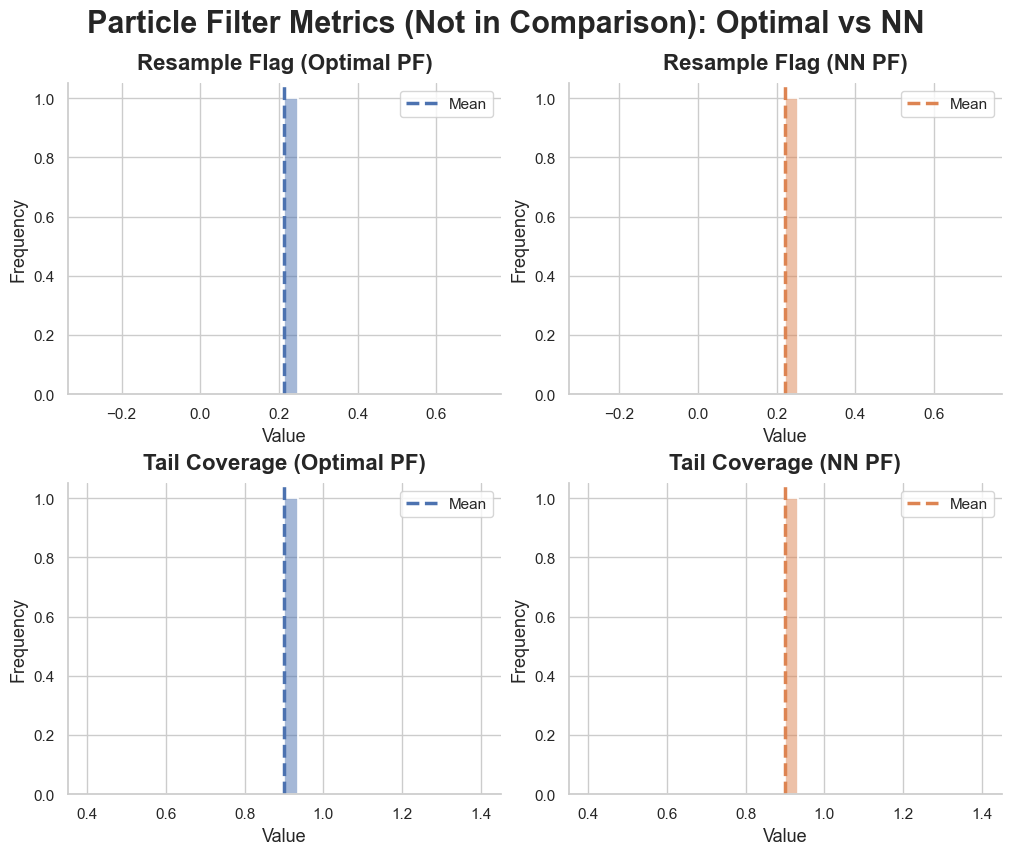

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")

n_metrics = len(not_in_comparison)
fig, axes = plt.subplots(n_metrics, 2, figsize=(10, 4 * n_metrics), constrained_layout=True)

if n_metrics == 1:
    axes = axes.reshape(1, 2)

for i, metric in enumerate(not_in_comparison):
    # Compute mean over axis=1 for both filters
    optimal_vals = jnp.mean(optimal_diagnostics[metric], axis=1)
    nn_vals = jnp.mean(nn_diagnostics[metric], axis=1)
    # Convert to numpy for plotting
    optimal_vals_np = jnp.asarray(optimal_vals).flatten()
    nn_vals_np = jnp.asarray(nn_vals).flatten()
    # Plot histogram for Optimal PF
    ax_opt = axes[i, 0]
    sns.histplot(optimal_vals_np, bins=30, kde=True, ax=ax_opt, color="#4C72B0", edgecolor="white", linewidth=1.2)
    ax_opt.axvline(float(jnp.mean(optimal_vals_np)), color="#4C72B0", linestyle="--", linewidth=2.5, label="Mean")
    ax_opt.set_title(f"{metric.replace('_', ' ').title()} (Optimal PF)", fontsize=16, weight='bold', pad=10)
    ax_opt.set_xlabel("Value", fontsize=13)
    ax_opt.set_ylabel("Frequency", fontsize=13)
    ax_opt.legend(fontsize=11)
    ax_opt.tick_params(axis='both', which='major', labelsize=11)
    ax_opt.spines['top'].set_visible(False)
    ax_opt.spines['right'].set_visible(False)
    # Plot histogram for NN PF
    ax_nn = axes[i, 1]
    sns.histplot(nn_vals_np, bins=30, kde=True, ax=ax_nn, color="#DD8452", edgecolor="white", linewidth=1.2)
    ax_nn.axvline(float(jnp.mean(nn_vals_np)), color="#DD8452", linestyle="--", linewidth=2.5, label="Mean")
    ax_nn.set_title(f"{metric.replace('_', ' ').title()} (NN PF)", fontsize=16, weight='bold', pad=10)
    ax_nn.set_xlabel("Value", fontsize=13)
    ax_nn.set_ylabel("Frequency", fontsize=13)
    ax_nn.legend(fontsize=11)
    ax_nn.tick_params(axis='both', which='major', labelsize=11)
    ax_nn.spines['top'].set_visible(False)
    ax_nn.spines['right'].set_visible(False)

plt.suptitle("Particle Filter Metrics (Not in Comparison): Optimal vs NN", fontsize=22, weight='bold', y=1.05)
plt.show()

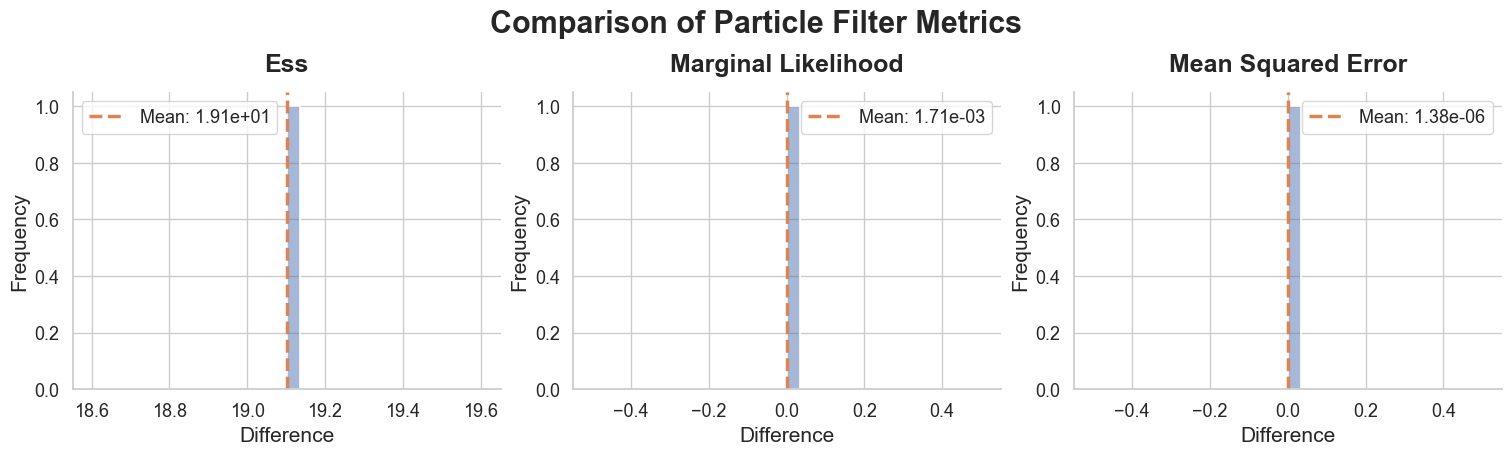

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")

fig, axes = plt.subplots(1, len(comparison_dict), figsize=(5 * len(comparison_dict), 4), constrained_layout=True)

if len(comparison_dict) == 1:
    axes = [axes]

for ax, (key, values) in zip(axes, comparison_dict.items()):
    values_np = jnp.asarray(values).flatten()
    mean_val = float(jnp.mean(values_np))
    sns.histplot(values_np, bins=30, kde=True, ax=ax, color="#4C72B0", edgecolor="white", linewidth=1.2)
    ax.axvline(mean_val, color="#DD8452", linestyle="--", linewidth=2.5, label=f"Mean: {mean_val:.2e}")
    ax.set_title(key.replace("_", " ").title(), fontsize=18, weight='bold', pad=15)
    ax.set_xlabel("Difference", fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Increase the space between the suptitle and the plots by adjusting the y parameter
plt.suptitle("Comparison of Particle Filter Metrics", fontsize=22, weight='bold', y=1.1)
plt.show()
